In [1]:
# Import library
import seaborn as sns
import pandas_profiling
import ipywidgets
from IPython.display import display, HTML
import scipy.stats as stats
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib
import seaborn as sns
%matplotlib inline
import itertools

#For sentiment analysis
from textblob import TextBlob

#Regression
from sklearn import preprocessing
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import mean_squared_error
from sklearn.metrics         import r2_score
from sklearn.metrics         import classification_report
from sklearn.metrics import mean_absolute_error
from pprint import pprint

from sklearn.pipeline        import Pipeline


from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model    import LinearRegression
from sklearn.svm             import SVC
from sklearn.svm             import SVR
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.compose import TransformedTargetRegressor

SEED = 123

## Loading Data

In [2]:
#df = pd.read_csv('Audible_data_updated.csv')
df = pd.read_csv('Audible_Dataset_final.csv')

In [3]:
#Changing column name of the last column to make it in format of the other Reviews
df = df.rename(columns={'Review100': 'Review 100'})

In [4]:
print('The shape of our dataset is:{}'.format(df.shape))

The shape of our dataset is:(2269, 110)


### Adding number of reviews column

In [5]:
#Creating a column that will contain the number of reviews in this dataset
df.insert(df.shape[1], 'nbr_reviews', '0')

In [6]:
#Counting the number of reviews
for index, row in df.iterrows():
    nbr_reviews = 0
    for review_j in range(1, 100):
        #Verifying if it's not a nan value
        if(row['Review '+str(review_j)] == row['Review '+str(review_j)]):
            nbr_reviews +=1
        df.at[index,'nbr_reviews'] = nbr_reviews

#### Checking the columns and their type of variables

In [7]:
df.columns

Index(['Book Title', 'Book Subtitle', 'Book Author', 'Book Narrator',
       'Audio Runtime', 'Audiobook_Type', 'Categories', 'Rating',
       'Total No. of Ratings', 'Price',
       ...
       'Review 92', 'Review 93', 'Review 94', 'Review 95', 'Review 96',
       'Review 97', 'Review 98', 'Review 99', 'Review 100', 'nbr_reviews'],
      dtype='object', length=111)

In [8]:
df.dtypes

Book Title       object
Book Subtitle    object
Book Author      object
Book Narrator    object
Audio Runtime    object
                  ...  
Review 97        object
Review 98        object
Review 99        object
Review 100       object
nbr_reviews      object
Length: 111, dtype: object

## Data cleaning for sentiment analysis of the reviews

#### Keeping only books with  rating number (betwwen 0 and 5)

In [9]:
#df.profile_report()

In [10]:
df[df['Rating'].notnull()]['Rating'].unique()

array(['5', '4.5', '4.8', 'Not rated yet', '4.6', '4.9', '4.7', '4.3',
       '4.2', '4.4', '4', '4.1', '5 out of 5 stars', '3.3', '3.9', '3.6',
       '3.8', '4.5 out of 5 stars', '2.3', '3', '1', '3.5', '2.5', '3.2',
       '1.8', '3.1', '2.8', '2.7', '3.4', '2.2', '2.9',
       '4 out of 5 stars', '3.7', '1.5'], dtype=object)

#### Cleaning the Rating column
- Removing null values
- Removing the one with label 'Not rated yet'
- Assign 5 to '5 out of 5 stars'
- Assign 4.5 to '4.5 out of 5 stars'
- Assign 4 to '4 out of 5 stars'

In [11]:
#Removing the one with label 'Not rated yet'
df = df[df['Rating'] != 'Not rated yet']

In [12]:
#Removing null values
df = df[df['Rating'].notnull()]

In [13]:
df['Rating'] = df['Rating'].apply(lambda x: '5' if(x=='5 out of 5 stars') else (x))
df['Rating'] = df['Rating'].apply(lambda x: '4.5' if(x=='4.5 out of 5 stars') else (x))
df['Rating'] = df['Rating'].apply(lambda x: '4' if(x=='4 out of 5 stars') else (x))
#df['Rating'] = df['Rating'].apply(lambda x: '5' if(x==19.95) else (x))
#df['Rating'] = df['Rating'].apply(lambda x: '5' if(x==14.95) else (x))
#converting Rating column to float
df['Rating'] = df['Rating'].astype(float)

In [14]:
df['Rating'].unique()

array([5. , 4.5, 4.8, 4.6, 4.9, 4.7, 4.3, 4.2, 4.4, 4. , 4.1, 3.3, 3.9,
       3.6, 3.8, 2.3, 3. , 1. , 3.5, 2.5, 3.2, 1.8, 3.1, 2.8, 2.7, 3.4,
       2.2, 2.9, 3.7, 1.5])

#### Converting Audio Runtime column to int

In [15]:
#Splitting time string 
df['Audio Runtime'] = df['Audio Runtime'].apply(lambda x: x.split( ))

In [16]:
#Computing the number of minutes
df['Audio Runtime'] = df['Audio Runtime'].apply(lambda x: int(x[0])*60 + int(x[3]) if(len(x)==5) else (int(x[0])))

#### converting price column into in

In [17]:
df['Price'] = df['Price'].apply(lambda x: float(x[1:]))
#1285

In [18]:
df['nbr_reviews'] = df['nbr_reviews'].astype(int)

In [19]:
df.dtypes

Book Title       object
Book Subtitle    object
Book Author      object
Book Narrator    object
Audio Runtime     int64
                  ...  
Review 97        object
Review 98        object
Review 99        object
Review 100       object
nbr_reviews       int64
Length: 111, dtype: object

In [20]:
df.columns

Index(['Book Title', 'Book Subtitle', 'Book Author', 'Book Narrator',
       'Audio Runtime', 'Audiobook_Type', 'Categories', 'Rating',
       'Total No. of Ratings', 'Price',
       ...
       'Review 92', 'Review 93', 'Review 94', 'Review 95', 'Review 96',
       'Review 97', 'Review 98', 'Review 99', 'Review 100', 'nbr_reviews'],
      dtype='object', length=111)

229


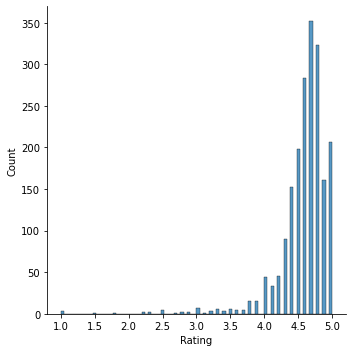

In [21]:
i=0
for nb in df.nbr_reviews:
    if nb == 0:
        i=i+1
print(i)

sns.displot(df, x="Rating")

## Sentiment analysis 

In [22]:
#Function assigning polarity to a Review
def polarity_to_text(blob):
    if (blob.sentiment.polarity > 0.1):
        #'Polarity is positive 😊'
        return 'postive'
    elif(blob.sentiment.polarity <= 0.1 and  blob.sentiment.polarity >= -0.1):
          # 'Polarity is neutral 😐'
        return 'neutral'
    else:
        # 'Polarity is negative 😡' 
        return 'negative'

In [23]:
#Function assigning polarity to just a score
def score_to_text(score):
    if (score > 0.1):
        #'Polarity is positive 😊'
        return 'postive'
    elif(score <= 0.1 and  score >= -0.1):
          # 'Polarity is neutral 😐'
        return 'neutral'
    else:
        # 'Polarity is negative 😡' 
        return 'negative'

In [24]:
#Adding polarity and score columns
for i in range(1, 101):
    df.insert(df.shape[1], 'polarity and score '+str(i),'0')
    
#Creating a column that will contain a list of all Reviews score
df.insert(df.shape[1], 'all scores', '0')

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3364: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


### Computing polarity scores

In [25]:
for index, row in df.iterrows():
    all_scores = []
    for review_j in range(1, 100):
        #Verifying if it's not a nan value
        if(row['Review '+str(review_j)] == row['Review '+str(review_j)]):
            blob = TextBlob(row['Review '+str(review_j)])
            emotion = polarity_to_text(blob)
            score = blob.sentiment.polarity
            # df.set_value(i,'polarity',emotion)
            df.at[index,'polarity and score '+str(review_j)] = [round(score, 2), emotion]
            all_scores.append(round(score, 2))
        else: 
            df.at[index,'polarity and score '+str(review_j)] = [0, '']
            all_scores.append(0)
        df.at[index,'all scores'] = all_scores 

### Computing mean score of all reviews and clustering 

In [26]:
#Creating a column mean_score
df.insert(df.shape[1], 'mean_score', '0')

In [27]:
df['mean_score'] = df.apply(lambda x: round(sum(x['all scores']) / x['nbr_reviews'], 2) if x['nbr_reviews'] !=0 else x['nbr_reviews'], axis=1)

In [28]:
#Creating a column mean_polarity
df.insert(df.shape[1], 'mean_polarity', '')

In [29]:
df['mean_polarity'] = df['mean_score'].apply(lambda x: score_to_text(x))

# Regressions

In [30]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #accuracy = 100 - mape
    mae = mean_absolute_error(test_labels,model.predict(test_features))
    r2score = r2_score(test_labels, predictions)
    print('Best Score: %s' % model.best_score_)
    print('Best Hyperparameters: %s' % model.best_params_)
    
    print('\n', 'Model Performance')
    #print('Average Error: {:0.4f} .'.format(np.mean(errors)))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Mean Absolute Error =  {:0.4f} .'.format(mae))
    print("Residual sum of squares: %.2f"
              % np.mean((model.predict(X_test) - y_test) ** 2))
    print('Mean Absolute Error Improvement of {:0.2f}%.'.format( -(mae - mae_baseline)*100/mae_baseline))
    print('R2 score = {:0.4f}.'.format(r2score))

    return 

In [31]:
def evaluateTTR(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #accuracy = 100 - mape
    mae = mean_absolute_error(test_labels,model.predict(test_features))
    r2score = r2_score(test_labels, predictions)
    #print('Best Score: %s' % model.best_score_)
    #print('Best Hyperparameters: %s' % model.best_params_)
    
    print('\n', 'Model Performance')
    #print('Average Error: {:0.4f} .'.format(np.mean(errors)))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('Mean Absolute Error =  {:0.4f} .'.format(mae))
    print("Residual sum of squares: %.2f"
              % np.mean((model.predict(X_test) - y_test) ** 2))
    print('Mean Absolute Error Improvement of {:0.2f}%.'.format( -(mae - mae_baseline)*100/mae_baseline))
    print('R2 score = {:0.4f}.'.format(r2score))

    return 

## Data cleaning for regressions

In [32]:
data = pd.concat([df.iloc[:, 0:10].copy(), df.nbr_reviews, df.mean_score, df.mean_polarity],axis = 1)  # To avoid the case where changing data also changes df

data.sample()


,Book Title,Book Subtitle,Book Author,Book Narrator,Audio Runtime,Audiobook_Type,Categories,Rating,Total No. of Ratings,Price,nbr_reviews,mean_score,mean_polarity
751,The Son of Neptune,"The Heroes of Olympus, Book Two",Rick Riordan,Joshua Swanson,807,Unabridged Audiobook,Children's Audiobooks,4.8,8870.0,31.5,99,0.33,postive


In [33]:
data = pd.get_dummies(data = data, columns = ['Book Author', 'Book Narrator', 'Audiobook_Type', 'Categories','mean_score','mean_polarity'])
features = list(set(list(data.columns)) - set(["Rating", "Book Subtitle", "Book Title"]))
X = data.loc[:, features]
Y = data.loc[:, 'Rating']
#Don't know how to use Book Subtitle in a usefull way - NLP stuff
data.shape

(1975, 2810)

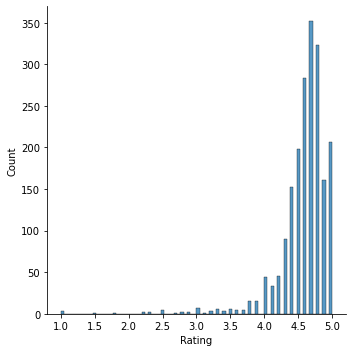

In [34]:
sns.displot(data, x="Rating")
#Observe a few outliers which are stopping me from creating a model.

In [35]:
#having an issue with singular target values on the models. Grouping for value lower then 2, lower than 3
for value in Y:
    if value <=1:
        Y.replace([value],1)
    if 1<value<=2 :
        Y = Y.replace([value],2)
    if 2<value <= 2.5:
        Y = Y.replace([value],2.5)
    if 2.5<value <= 3:
        Y = Y.replace([value],3)
    if 3<value <=3.5:
        Y = Y.replace([value],3.5)
    if 3.5< value <= 3.75:
        Y = Y.replace([value],3.75)

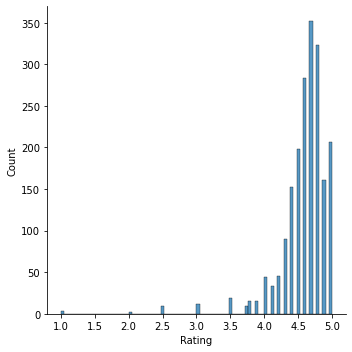

In [36]:
sns.displot(Y)
#Sanity check that previous code worked and we don't have any singular outlier

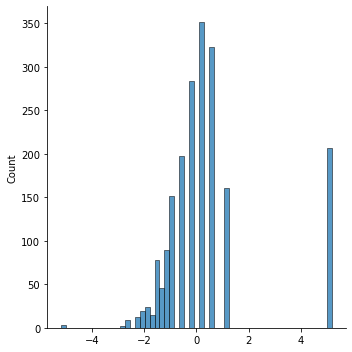

In [37]:
#Changing distribution as data is very skewed
Y_trans = quantile_transform(Y.to_frame(), 
                             n_quantiles=500, 
                             output_distribution='normal', 
                             copy=True
                            ).squeeze()
sns.displot(Y_trans)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state = SEED)
#Could not use stratify due to low counts of some variables

In [39]:
#lab_enc = preprocessing.LabelEncoder()
#for name in X.columns:
#    X[name] = lab_enc.fit_transform(X[name])
#Y = lab_enc.fit_transform(Y)

In [40]:
Nb_cv = 3

In [41]:
# define standard scaler
scaler = StandardScaler()

## Baseline Model

In [42]:
y_pred = [np.mean(y_train)]*len(y_test)
print("Average rating", np.round(np.mean(y_train), decimals = 2))
mae_baseline = mean_absolute_error(y_test, y_pred)
print("Baseline mean absolute error: {:0.4f}.".format(mae_baseline))
r2_baseline = r2_score(y_test, y_pred)
print("Baseline r2 score: {:0.1f}.".format(r2_baseline))

Average rating 4.59
Baseline mean absolute error: 0.2439.
Baseline r2 score: -0.0.


## Linear Model

In [43]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('Linear', LinearRegression()))  # tell it to use a linear reg model
model = Pipeline(estimators) 
space = {'Linear__fit_intercept':[True,False], 
              'Linear__copy_X':[True, False],
             'Linear__positive': [True, False]}
search_lin_reg = GridSearchCV(model,space, cv=Nb_cv, scoring='r2')


In [44]:
# Finding the best model
lin_reg_result = search_lin_reg.fit(X_train, y_train)

In [45]:
# summarize result
evaluate(lin_reg_result, X_test, y_test)

Best Score: -1.0209761901303733e+26
Best Hyperparameters: {'Linear__copy_X': True, 'Linear__fit_intercept': True, 'Linear__positive': True}

 Model Performance
Mean Absolute Error =  2.3966 .
Residual sum of squares: 8.74
Mean Absolute Error Improvement of -882.68%.
R2 score = -57.5829.


In [46]:
# Testing!
model_trans_lin = TransformedTargetRegressor(
    regressor=search_lin_reg,
    transformer=QuantileTransformer(n_quantiles=500, output_distribution="normal"),
)
test_model_lin = model_trans_lin.fit(X_train, y_train)
y_pred = test_model_lin.predict(X_test)


In [47]:
# summarize result
evaluateTTR(test_model_lin, X_test, y_test)


 Model Performance
Mean Absolute Error =  2.3484 .
Residual sum of squares: 8.27
Mean Absolute Error Improvement of -862.92%.
R2 score = -54.4389.


## Ridge Model

In [48]:
# define model
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('Ridge', Ridge()))  # tell it to use a ridge model
model_ridge = Pipeline(estimators) 
# define search space
space = dict()
space['Ridge__solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['Ridge__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space['Ridge__fit_intercept'] = [True, False]
# define search
search_ridge = GridSearchCV(model_ridge, space, scoring='r2', n_jobs=-1, cv=Nb_cv)
#Chose what scoring we want to use


In [49]:
# execute search
Ridge_result = search_ridge.fit(X_train, y_train)
# summarize result
evaluate(Ridge_result, X_test, y_test)

Best Score: 0.1711510038910272
Best Hyperparameters: {'Ridge__alpha': 100, 'Ridge__fit_intercept': True, 'Ridge__solver': 'sag'}

 Model Performance
Mean Absolute Error =  0.2221 .
Residual sum of squares: 0.14
Mean Absolute Error Improvement of 8.94%.
R2 score = 0.0950.


In [50]:
# Testing!
model_trans = TransformedTargetRegressor(
    regressor=search_ridge,
    transformer=QuantileTransformer(n_quantiles=500, output_distribution="normal"),
)
test_model_ridge = model_trans.fit(X_train, y_train)
y_pred = test_model_ridge.predict(X_test)


KeyboardInterrupt: 

In [ ]:
# summarize result
evaluateTTR(test_model_ridge, X_test, y_test)

## Lasso Model

In [241]:
# define model
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('Lasso', Lasso()))  # tell it to use a lasso model
model_lasso = Pipeline(estimators) 
# define search space
space_las = dict()
#space_las['Lasso__solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space_las['Lasso__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
space_las['Lasso__fit_intercept'] = [True, False]
# define search
search_lasso = GridSearchCV(model_lasso, space_las, scoring='r2', n_jobs=-1, cv=Nb_cv)



In [242]:
# execute search
Lasso_result = search_lasso.fit(X_train, y_train)
# summarize result
evaluate(Lasso_result, X_test, y_test)

Best Score: 0.15084956851459452
Best Hyperparameters: {'Lasso__alpha': 0.01, 'Lasso__fit_intercept': True}

 Model Performance
Mean Absolute Error =  0.2295 .
Residual sum of squares: 0.16
Mean Absolute Error Improvement of 5.89%.
R2 score = -0.0869.


In [243]:
# Testing!
model_trans = TransformedTargetRegressor(
    regressor=search_lasso,
    transformer=QuantileTransformer(n_quantiles=500, output_distribution="normal"),
)
test_model_lasso = model_trans.fit(X_train, y_train)
y_pred = test_model_lasso.predict(X_test)


In [244]:
# summarize result
evaluateTTR(test_model_lasso, X_test, y_test)


 Model Performance
Mean Absolute Error =  0.2255 .
Residual sum of squares: 0.18
Mean Absolute Error Improvement of 7.55%.
R2 score = -0.2177.


## SVR Model

In [33]:
# define model
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('SVR', SVR()))  # tell it to use a SVR model
model_SVR = Pipeline(estimators) 
# defining parameter range
param_grid = {'SVR__C': [0.1, 1, 10, 100],
              'SVR__gamma': [1, 0.1, 0.01, 0.001],
              }
#Define search
search_SVR = GridSearchCV(model_SVR, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=Nb_cv)

#Execute search
SVR_result = search_SVR.fit(X_train, y_train)

# print best parameter after tuning
print(search_SVR.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(search_SVR.best_estimator_)

search_predictions = search_SVR.predict(X_test)

{'SVR__C': 1, 'SVR__gamma': 0.001}
Pipeline(steps=[('standardize', StandardScaler()),
                ('SVR', SVR(C=1, gamma=0.001))])


In [34]:
# summarize result
evaluate(SVR_result, X_test, y_test)

Best Score: -0.21445272172776142
Best Hyperparameters: {'SVR__C': 1, 'SVR__gamma': 0.001}

 Model Performance
Mean Absolute Error =  0.2299 .
Residual sum of squares: 0.12
Mean Absolute Error Improvement of 4.58%.
R2 score = 0.0826.


In [182]:
# Testing!
model_trans_SVR = TransformedTargetRegressor(
    regressor=search_SVR,
    transformer=QuantileTransformer(n_quantiles=500, output_distribution="normal"),
)
test_model_SVR = model_trans_SVR.fit(X_train, y_train)
y_pred = SVR_result.predict(X_test)


In [183]:
# summarize result
evaluateTTR(test_model_SVR, X_test, y_test)


 Model Performance
Mean Absolute Error =  0.2160 .
Residual sum of squares: 0.13
Mean Absolute Error Improvement of 10.33%.
R2 score = 0.0310.


## Random Forest Model

In [35]:
rf = RandomForestRegressor(random_state = SEED)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}


In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 120, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
pprint(random_grid)

{'max_depth': [10, 37, 65, 92, 120, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 650, 1100, 1550, 2000]}


In [39]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = Nb_cv, scoring='neg_mean_absolute_error', random_state=SEED, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 37, 65, 92, 120,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=123, scoring='neg_mean_absolute_error')

In [40]:
rf_random.best_params_

{'n_estimators': 650,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 120}

In [43]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = SEED)
base_model.fit(X_train, y_train)
base_accuracy = evaluateTTR(base_model, X_test, y_test)


best_random = rf_random.best_estimator_
random_accuracy = evaluateTTR(best_random, X_test, y_test)


#print('Improvement of ', 100 * (random_accuracy - base_accuracy) / base_accuracy)



 Model Performance
Mean Absolute Error =  0.2089 .
Residual sum of squares: 0.14
Mean Absolute Error Improvement of 13.27%.
R2 score = -0.0792.

 Model Performance
Mean Absolute Error =  0.1972 .
Residual sum of squares: 0.13
Mean Absolute Error Improvement of 18.14%.
R2 score = 0.0447.


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [44]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [110, 120, 130],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [550, 650, 700]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          scoring='neg_mean_absolute_error', n_jobs=-1, cv=Nb_cv)

In [45]:
# Fit the grid search to the data
rf_result = search_rf.fit(X_train, y_train)
best_grid = search_rf.best_estimator_

KeyboardInterrupt: 

In [ ]:
# summarize result
evaluate(rf_result, X_test, y_test)

In [182]:
# Testing!
model_trans = TransformedTargetRegressor(
    regressor=rf_result,
    transformer=QuantileTransformer(n_quantiles=500, output_distribution="normal"),
)
test_model_SVR = rf_result.fit(X_train, y_train)
y_pred = rf_result.predict(X_test)


In [183]:
# summarize result
evaluateTTR(test_model_SVR, X_test, y_test)


 Model Performance
Mean Absolute Error =  0.2160 .
Residual sum of squares: 0.13
Mean Absolute Error Improvement of 10.33%.
R2 score = 0.0310.


## KNN

In [42]:
# define model
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('KNN', KNeighborsRegressor()))  # tell it to use a KNN model
model_KNN = Pipeline(estimators) 

print('Parameters currently in use:\n')
pprint(model_KNN.get_params())

k_range = list(range(1, 31))
space = dict()
space['KNN__n_neighbors']=k_range
space['KNN__leaf_size']=[5, 10, 20, 30, 40, 50]

Parameters currently in use:

{'KNN': KNeighborsRegressor(),
 'KNN__algorithm': 'auto',
 'KNN__leaf_size': 30,
 'KNN__metric': 'minkowski',
 'KNN__metric_params': None,
 'KNN__n_jobs': None,
 'KNN__n_neighbors': 5,
 'KNN__p': 2,
 'KNN__weights': 'uniform',
 'memory': None,
 'standardize': StandardScaler(),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'steps': [('standardize', StandardScaler()), ('KNN', KNeighborsRegressor())],
 'verbose': False}


In [43]:
# defining parameter range
search_KNN = GridSearchCV(model_KNN, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=Nb_cv)


In [44]:
# fitting the model for grid search
KNN_result=search_KNN.fit(X_train, y_train)

# print best parameter after tuning
print(search_KNN.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(search_KNN.best_estimator_)

search_predictions = search_KNN.predict(X_test)

{'KNN__leaf_size': 5, 'KNN__n_neighbors': 4}
Pipeline(steps=[('standardize', StandardScaler()),
                ('KNN', KNeighborsRegressor(leaf_size=5, n_neighbors=4))])


In [45]:
# summarize result
evaluate(KNN_result, X_test, y_test)


 Model Performance
Mean Absolute Error =  0.2340 .
Residual sum of squares: 0.15
Mean Absolute Error Improvement of 2.86%.
R2 score = -0.0882.


In [50]:
# Testing!
model_trans = TransformedTargetRegressor(
    regressor=search_KNN,
    transformer=QuantileTransformer(n_quantiles=100, output_distribution="normal"),
)
test_model = model_trans.fit(X_train, y_train)
y_pred = test_model.predict(X_test)


In [51]:
# summarize result
evaluate(test_model, X_test, y_test)


 Model Performance
Mean Absolute Error =  0.2633 .
Residual sum of squares: 0.21
Mean Absolute Error Improvement of -9.29%.
R2 score = -0.5355.


ImportError: cannot import name 'get_config' from 'tensorflow.python.eager.context' (/Applications/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/context.py)